### Import packages and define constants

In [158]:
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt


# Plots
%matplotlib inline
font = {
    'family' : 'serif',
    'weight' : 'normal',
    'size'   : 12
}
plt.rc('font', **font)
PDF= True # A boolean value speficifying whether the figures should be exported to PDF

# System information
# ieee14: 27 components
# ieee57: 100 components
SYS = 'ieee14'
N_COMP = 27 # Number of components in the system

# Input files
SEQ_DIR = 'failure_seq'
INIT_FILE = os.path.join(SEQ_DIR, SYS + '_smart_initial.txt')
RESULT_FILE = os.path.join(SEQ_DIR, SYS + '_smart_result.txt')
CMPLX_INIT_FILE = os.path.join(SEQ_DIR, SYS + '_smart_cmplx_initial.txt')
CMPLX_RESULT_FILE = os.path.join(SEQ_DIR, SYS + '_smart_cmplx_result.txt')

# Neural network
N_STEPS = 5000 # Number of training steps
REC_INT = 100 # Number of steps between recording measures
VERBOSE = True # A boolean value speficifying whether the performance measures should be printed every REC_INT steps
BATCH_SIZE = 128 # Size of the batch for training
N_HIDDEN_L = 256 # Number of nodes in outer hidden layers
N_HIDDEN_M = 128 # Number of nodes in middle hidden layers
N_HIDDEN_S = 64 # Number of nodes in centeral hidden layers
TEST_SIZE = 0.10 # Portion of data to be used for testing
VALID_SIZE = 0.10 # Portion of data to be used for validation
LEARNING_RATE = 0.005 # Ratio of knowledge to learn at each new step as compared to previously established knowledge
REGULATION_RATE = 2e-6 # Penalizing factor for increased weights (prevents overfitting)
FAILURE_THRESHOLD = 0.90 # Threshold for deciding failed/functional state for components in the predictions
SEED = 1818 # Seed for random number generators

### Read initial and resulting failures

In [159]:
init_data = np.zeros((1, N_COMP))
with open(INIT_FILE, 'r') as init_file:
    for i, line in enumerate(init_file):
        indices = line.split()
        l = np.zeros((1, N_COMP))
        if len(indices) > 1:
            l[0, indices[1:]] = 1
        init_data = np.append(init_data, l, 0)
            
if os.path.isfile(CMPLX_INIT_FILE):
    cmplx_init_data = np.zeros((0, N_COMP))
    with open(CMPLX_INIT_FILE, 'r') as cmplx_init_file:
        for i, line in enumerate(cmplx_init_file):
            indices = line.split()
            l = np.zeros((1, N_COMP))
            if len(indices) > 1:
                l[0, indices[1:]] = 1
            cmplx_init_data = np.append(cmplx_init_data, l, 0)

result_data = np.zeros((1, N_COMP))
with open(RESULT_FILE, 'r') as result_file:
    for i, line in enumerate(result_file):
        indices = line.split()
        l = np.zeros((1, N_COMP))
        if len(indices) > 1:
            l[0, indices[1:]] = 1
        result_data = np.append(result_data, l, 0)

if os.path.isfile(CMPLX_RESULT_FILE):
    cmplx_result_data = np.zeros((0, N_COMP))
    with open(CMPLX_RESULT_FILE, 'r') as cmplx_result_file:
        for i, line in enumerate(cmplx_result_file):
            indices = line.split()
            l = np.zeros((1, N_COMP))
            if len(indices) > 1:
                l[0, indices[1:]] = 1
            cmplx_result_data = np.append(cmplx_result_data, l, 0)

print('Simple dataset: {}, Complex dataset: {}'.format(init_data.shape[0], cmplx_init_data.shape[0]))

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


Simple dataset: 17969, Complex dataset: 1423


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:36: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


### Split data to training, test, and validation

In [160]:
x_train_valid, x_test, y_train_valid, y_test = train_test_split(
    init_data, result_data, test_size=int(TEST_SIZE*init_data.shape[0]), random_state=SEED)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_valid, y_train_valid, test_size=int(VALID_SIZE*init_data.shape[0]), random_state=SEED)
#_, x_train, _, y_train = train_test_split(
#    x_train, y_train, test_size=250, random_state=SEED)
x_cmplx_test, y_cmplx_test = cmplx_init_data, cmplx_result_data
print('Training: {}, Validation: {}, Test: {}, Complex Test: {}'.format(
        x_train.shape[0], x_valid.shape[0], x_test.shape[0], x_cmplx_test.shape[0]))

Training: 14377, Validation: 1796, Test: 1796, Complex Test: 1423


### Classification and performance

In [155]:
def decision(predictions, threshold=0.5):
    if isinstance(predictions, float):
        return predictions > threshold
    elif predictions.ndim == 1:
        return predictions > threshold * 1 #np.amax(predictions)
    elif predictions.ndim == 2:
        return predictions > threshold * 1 #np.amax(predictions, 1)[np.newaxis].T
    return None

def performance(actual, predictions_bin, beta=1):
    act = np.empty(shape=[0, actual.shape[1]])
    pre = np.empty(shape=[0, predictions_bin.shape[1]])
    for i in range(actual.shape[0]):
        if any(actual[i, :]) and any(predictions_bin[i, :]):
            act = np.append(act, actual[i, :][np.newaxis], 0)
            pre = np.append(pre, predictions_bin[i, :][np.newaxis], 0)
    accuracy = np.sum(predictions_bin == actual) / predictions_bin.size
    if act.size > 0 and pre.size > 0:
        precision, recall, fscore, _ = precision_recall_fscore_support(
            act, pre, average='samples', beta=beta)
    else:
        precision, recall, fscore = (0, 0, 0)
    return {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'fscore': fscore}

### Neural network model

In [156]:
graph = tf.Graph()
with graph.as_default():
    # Inputs
    tf_train_dataset = tf.placeholder(shape=(BATCH_SIZE, N_COMP), dtype=tf.float64)
    tf_train_labels = tf.placeholder(shape=(BATCH_SIZE, N_COMP), dtype=tf.float64)
    tf_valid_dataset = tf.constant(x_valid)
    tf_valid_labels = tf.constant(y_valid)
    tf_test_dataset = tf.constant(x_test)
    tf_test_labels = tf.constant(y_test)
    tf_cmplx_test_dataset = tf.constant(x_cmplx_test)
    tf_cmplx_test_labels = tf.constant(y_cmplx_test)
    
    # Layer 1
    weights_1 = tf.get_variable("weights_1", shape=[N_COMP, N_HIDDEN_L],
                                initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float64)
    biases_1 = tf.Variable(tf.zeros([N_HIDDEN_L], dtype=tf.float64))
    # Layer 2
    weights_2 = tf.get_variable("weights_2", shape=[N_HIDDEN_L, N_HIDDEN_M],
                                initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float64)
    biases_2 = tf.Variable(tf.zeros([N_HIDDEN_M], dtype=tf.float64))
    # Layer 3
    weights_3 = tf.get_variable("weights_3", shape=[N_HIDDEN_M, N_HIDDEN_S],
                                initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float64)
    biases_3 = tf.Variable(tf.zeros([N_HIDDEN_S], dtype=tf.float64))
    # Layer 4
    weights_4 = tf.get_variable("weights_4", shape=[N_HIDDEN_S, N_HIDDEN_M],
                                initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float64)
    biases_4 = tf.Variable(tf.zeros([N_HIDDEN_M], dtype=tf.float64))
    # Layer 5
    weights_5 = tf.get_variable("weights_5", shape=[N_HIDDEN_M, N_HIDDEN_L],
                                initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float64)
    biases_5 = tf.Variable(tf.zeros([N_HIDDEN_L], dtype=tf.float64))
    # Output layer
    weights_out = tf.get_variable("weights_out", shape=[N_HIDDEN_L, N_COMP],
                                initializer=tf.contrib.layers.xavier_initializer(), dtype=tf.float64)
    biases_out = tf.Variable(tf.zeros([N_COMP], dtype=tf.float64))
    
    def model(input_data):
        activation_1 = tf.nn.relu(tf.matmul(input_data, weights_1) + biases_1)
        activation_2 = tf.nn.relu(tf.matmul(activation_1, weights_2) + biases_2)
        #activation_3 = tf.nn.relu(tf.matmul(activation_2, weights_3) + biases_3)
        #activation_4 = tf.nn.relu(tf.matmul(activation_3, weights_4) + biases_4)
        activation_5 = tf.nn.relu(tf.matmul(activation_2, weights_5) + biases_5)
        return activation_5
    
    # Training
    activation_model = model(tf_train_dataset)
    logits_train = tf.matmul(activation_model, weights_out) + biases_out
    loss_train = (tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits_train, tf_train_labels)) +
                  REGULATION_RATE * tf.nn.l2_loss(weights_1))
  
    # Optimizer
    # TODO - Try other optimizers and adjust learning rate. Weight decay is an option
    optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss_train)
  
    # Predictions
    logits_valid = tf.matmul(model(tf_valid_dataset), weights_out) + biases_out
    loss_valid = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits_valid, tf_valid_labels))
    sigmoid_valid = tf.nn.sigmoid(logits_valid)
    logits_test = tf.matmul(model(tf_test_dataset), weights_out) + biases_out
    sigmoid_test = tf.nn.sigmoid(logits_test)
    logits_cmplx_test = tf.matmul(model(tf_cmplx_test_dataset), weights_out) + biases_out
    sigmoid_cmplx_test = tf.nn.sigmoid(logits_cmplx_test)

### Train the neural network

In [157]:
with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    ls_train_log = []
    ls_valid_log = []
    perf_valid_log = []
    print('Training the network...')
    for step in range(N_STEPS + 1):
        offset = (step * BATCH_SIZE) % (y_train.shape[0] - BATCH_SIZE)
        batch_data = x_train[offset:(offset + BATCH_SIZE), :]
        batch_labels = y_train[offset:(offset + BATCH_SIZE), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, ls_train, ls_valid, sg_valid = session.run(
            [optimizer, loss_train, loss_valid, sigmoid_valid], feed_dict=feed_dict)
        ls_train_log.append(ls_train)
        ls_valid_log.append(ls_valid)
        perf_valid = performance(y_valid, decision(sg_valid, FAILURE_THRESHOLD))
        perf_valid_log.append(perf_valid)
        if (VERBOSE and step == 0):
            print('Step\tTR-Loss\t\tVL-Loss\t\tAccuracy\tRecall\t\tPrecision\tF-Score')
            print('-' * 95)
        if VERBOSE and step % REC_INT == 0:
            print((
                    '{step:5d}\t'
                    '{tr_loss:.4f}\t\t'
                    '{vl_loss:.4f}\t\t'
                    '{p[accuracy]:.2%}\t\t'
                    '{p[recall]:.2%}\t\t'
                    '{p[precision]:.2%}\t\t'
                    '{p[fscore]:.2%}').format(
                    step=step,
                    tr_loss=ls_train,
                    vl_loss=ls_valid,
                    p=perf_valid)
                 )
    if VERBOSE:
        print('-' * 95)
    sg_test = sigmoid_test.eval()
    print(5 * '\t' + 'Accuracy\tRecall\t\tPrecision\tF-Score')
    print((
            'Test Dataset:\t\t\t\t'
            '{p[accuracy]:.2%}\t\t'
            '{p[recall]:.2%}\t\t'
            '{p[precision]:.2%}\t\t'
            '{p[fscore]:.2%}').format(
            p=performance(y_test, decision(sg_test, FAILURE_THRESHOLD)))
         )
    if VERBOSE:
        print('-' * 95)
    sg_cmplx_test = sigmoid_cmplx_test.eval()
    print(5 * '\t' + 'Accuracy\tRecall\t\tPrecision\tF-Score')
    print((
            'More Complex Test Dataset:\t\t'
            '{p[accuracy]:.2%}\t\t'
            '{p[recall]:.2%}\t\t'
            '{p[precision]:.2%}\t\t'
            '{p[fscore]:.2%}').format(
            p=performance(y_cmplx_test, decision(sg_cmplx_test, FAILURE_THRESHOLD)))
         )

Training the network...
Step	TR-Loss		VL-Loss		Accuracy	Recall		Precision	F-Score
-----------------------------------------------------------------------------------------------
    0	0.6919		0.6556		99.40%		0.00%		0.00%		0.00%
  100	0.0120		0.0312		99.40%		100.00%		100.00%		100.00%
  200	0.0009		0.0508		99.43%		71.65%		81.33%		74.46%
  300	0.0002		0.0576		99.45%		70.42%		79.48%		73.26%
  400	0.0002		0.0612		99.45%		71.92%		81.35%		74.81%
  500	0.0002		0.0627		99.45%		71.01%		79.20%		73.44%
  600	0.0002		0.0647		99.46%		72.13%		79.89%		74.43%
  700	0.0001		0.0656		99.47%		73.18%		79.68%		75.08%
  800	0.0001		0.0664		99.47%		74.16%		80.81%		76.12%
  900	0.0001		0.0669		99.47%		74.25%		80.61%		76.07%
 1000	0.0001		0.0673		99.47%		73.79%		80.52%		75.77%
 1100	0.0001		0.0675		99.48%		73.83%		80.36%		75.75%
 1200	0.0001		0.0676		99.48%		74.80%		81.03%		76.59%
 1300	0.0011		0.0666		99.49%		75.08%		80.79%		76.64%
 1400	0.0008		0.0664		99.47%		74.98%		82.19%		77.20%
 1500	0.0001		0.0722		99.44

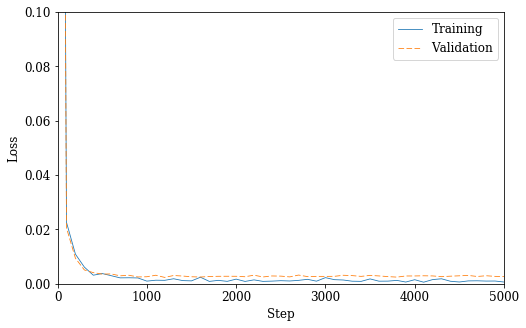

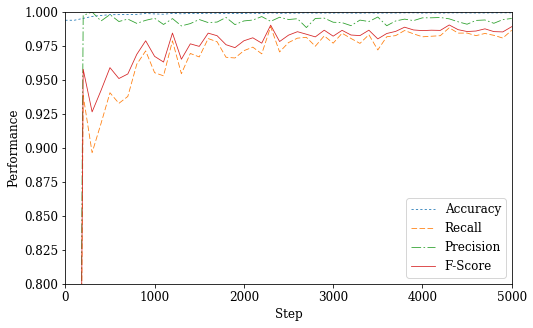

In [51]:
acc_log = [x['accuracy'] for x in perf_valid_log[0::REC_INT]]
rec_log = [x['recall'] for x in perf_valid_log[0::REC_INT]]
pre_log = [x['precision'] for x in perf_valid_log[0::REC_INT]]
fsc_log = [x['fscore'] for x in perf_valid_log[0::REC_INT]]

n = len(ls_train_log) // REC_INT
x = np.arange(0, REC_INT * n + 1, REC_INT)
fig_loss = plt.figure(figsize=(8, 5))
plt.plot(x, ls_train_log[0::REC_INT], '-C0', x, ls_valid_log[0::REC_INT], 'C1--', linewidth=0.8)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.xlim(0, REC_INT * n)
plt.ylim(0, 0.1)
plt.legend(('Training', 'Validation'))
plt.show()
if PDF:
    fig_loss.savefig(SYS + '_nn_loss.pdf', bbox_inches='tight')

fig_perf = plt.figure(figsize=(8, 5))
acc_max = (REC_INT * np.argmax(acc_log), np.amax(acc_log))
rec_max = (REC_INT * np.argmax(rec_log), np.amax(rec_log))
pre_max = (REC_INT * np.argmax(pre_log), np.amax(pre_log))
fsc_max = (REC_INT * np.argmax(fsc_log), np.amax(fsc_log))
plt.plot(x, acc_log, ':C0',
         #acc_max[0], acc_max[1], 'C0s', 
         x, rec_log, '--C1',
         #rec_max[0], rec_max[1], 'C1s',
         x, pre_log, '-.C2',
         #pre_max[0], pre_max[1], 'C2s',
         x, fsc_log, '-C3',
         #fsc_max[0], fsc_max[1], 'C3s'
         linewidth=0.8
        )
plt.xlim(0, REC_INT * n)
plt.ylim(0.8, 1)
plt.xlabel('Step')
plt.ylabel('Performance')
plt.legend(('Accuracy',
            #'Maximum Accuracy: {m[1]:.2%} at step {m[0]}'.format(m=acc_max),
            'Recall',
            #'Maximum Recall: {m[1]:.2%} at step {m[0]}'.format(m=rec_max),
            'Precision',
            #'Maximum Precision: {m[1]:.2%} at step {m[0]}'.format(m=pre_max),
            'F-Score',
            #'Maximum F-score: {m[1]:.2%} at step {m[0]}'.format(m=fsc_max)
           ))

plt.show()
if PDF:
    fig_perf.savefig(SYS + '_nn_perf.pdf', bbox_inches='tight')

In [62]:
def predict_test(case, threshold=0.5):
    if case > x_test.shape[0]:
        print('Case number does not exist')
        return
    print('Case {}'.format(case))
    print('Initial Failures: {}'.format(np.nonzero(x_test[case])[0].tolist()))
    print('Resulting Failures: {}'.format(np.nonzero(y_test[case])[0].tolist()))
    print('Predicted Failures: {}'.format(
            np.nonzero(decision(sg_test[case], threshold))[0].tolist()))

predict_test(0, FAILURE_THRESHOLD)
predict_test(1, FAILURE_THRESHOLD)
predict_test(3, FAILURE_THRESHOLD)
predict_test(13, FAILURE_THRESHOLD)
predict_test(77, FAILURE_THRESHOLD)
predict_test(125, FAILURE_THRESHOLD)

Case 0
Initial Failures: [57, 80, 91, 99]
Resulting Failures: []
Predicted Failures: []
Case 1
Initial Failures: [15, 26, 80, 85, 95, 99]
Resulting Failures: [14, 83]
Predicted Failures: [14, 83]
Case 3
Initial Failures: [18, 86, 91, 99]
Resulting Failures: []
Predicted Failures: []
Case 13
Initial Failures: [14, 15, 16, 83, 84, 98, 99]
Resulting Failures: [0]
Predicted Failures: [0]
Case 77
Initial Failures: [7, 21, 81, 82, 97]
Resulting Failures: [6]
Predicted Failures: []
Case 125
Initial Failures: [64, 85, 89]
Resulting Failures: []
Predicted Failures: []


Initial Failures: [1, 15, 16, 17, 84, 85, 95, 100]


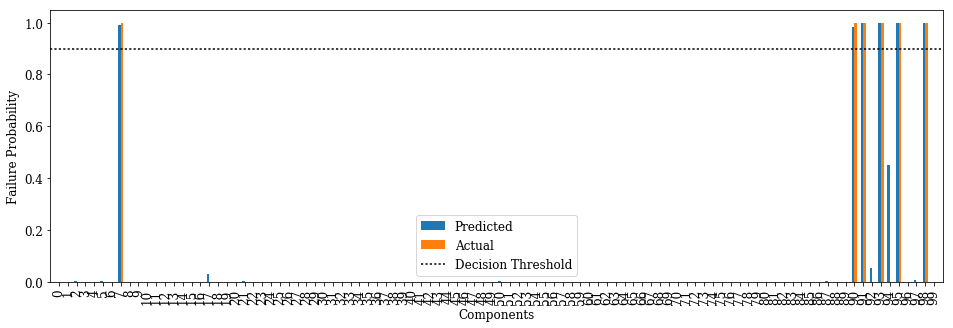

In [18]:
def plot_predict_test(case, w=0.3, threshold=0.5):
    print('Initial Failures: {}'.format((np.nonzero(x_test[case])[0] + 1).tolist()))
    fig_pred = plt.figure(figsize=(16, 5))
    prd = plt.bar(np.arange(N_COMP) - w/2, sg_test[case], w)
    act = plt.bar(np.arange(N_COMP) + w/2, y_test[case], w)
    thr = plt.plot(np.arange(-1, N_COMP + 1), np.full(N_COMP + 2, threshold), ':k')
    plt.xlabel('Components')
    plt.ylabel('Failure Probability')
    plt.xticks(np.arange(N_COMP), rotation=90)
    plt.legend((prd[0], act[0], thr[0]), ('Predicted', 'Actual', 'Decision Threshold'))
    plt.xlim(-1, N_COMP)
    plt.show()
    if PDF:
        fig_pred.savefig(SYS + '_nn_' + str(case) + '_pred.pdf', bbox_inches='tight')

plot_predict_test(141, threshold=FAILURE_THRESHOLD)

In [14]:
a = []
for i, row in enumerate(sg_test):
    if any(np.logical_and(sg_test[i, :] > 0.3, sg_test[i, :] < 0.7)) and np.sum(y_test[i, :] > FAILURE_THRESHOLD) > 1:
        a.append(i)
print(a)

[141, 172, 178, 268, 377, 575, 1127, 1147, 1326, 1399, 2033, 2389, 2440, 2455, 2591]


In [89]:
b = []
for i, row in enumerate(sg_test):
    if not any(decision(sg_test[i, :], FAILURE_THRESHOLD)):
        b.append(i)
print(b)

[0, 2, 6, 7, 8, 13, 14, 16, 19, 25, 27, 29, 33, 34, 35, 48, 50, 52, 53, 57, 58, 59, 61, 62, 63, 66, 71, 75, 79, 80, 81, 84, 87, 88, 92, 93, 100, 102, 103, 110, 111, 114, 115, 116, 117, 118, 121, 126, 128, 130, 132, 133, 134, 136, 139, 142, 143, 146, 147, 151, 154, 155, 159, 163, 164, 167, 168, 169, 173, 176, 177, 179, 182, 185, 189, 190, 191, 197, 202, 213, 215, 216, 218, 220, 223, 226, 227, 230, 234, 240, 241, 242, 243, 246, 247, 248, 249, 257, 258, 260, 261, 262, 263, 264, 267, 268, 269, 270, 271, 272, 275, 278, 280, 282, 283, 284, 290, 292, 293, 294, 298, 299, 309, 316, 318, 320, 324, 325, 333, 334, 341, 344, 353, 358, 360, 362, 364, 366, 370, 372, 375, 377, 381, 383, 388, 389, 392, 394, 398, 400, 401, 403, 407, 411, 412, 420, 424, 427, 429, 431, 432, 434, 445, 454, 456, 458, 460, 462, 463, 465, 467, 471, 473, 474, 475, 476, 479, 482, 491, 493, 494, 495, 497, 501, 504, 508, 509, 510, 514, 515, 516, 525, 526, 527, 528, 529, 530, 532, 534, 538, 541, 543, 548, 550, 552, 554, 558, 560, 

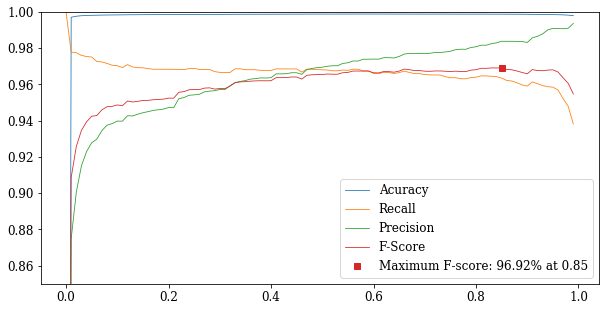

In [36]:
def fscore_curve(start=0, stop=1, step=0.01):
    p = []
    threshold = np.arange(start, stop, step)
    for t in threshold:
        p.append(performance(y_valid, decision(sg_valid, t)))
    acc = [x['accuracy'] for x in p]
    rec = [x['recall'] for x in p]
    pre = [x['precision'] for x in p]
    fsc = [x['fscore'] for x in p]
    fig_thr = plt.figure(figsize=(10, 5))
    plt.plot(
        threshold, acc, 'C0',
        threshold, rec, 'C1',
        threshold, pre, 'C2',
        threshold, fsc, 'C3',
        threshold[np.argmax(fsc)], np.amax(fsc), 'C3s',
        linewidth=0.8)
    plt.legend((
            'Acuracy',
            'Recall',
            'Precision',
            'F-Score',
            'Maximum F-score: {:.2%} at {:.2f}'.format(np.amax(fsc), threshold[np.argmax(fsc)])))
    plt.ylim(0.85, 1)
    plt.show()
    if PDF:
        fig_thr.savefig('nn_threshold.pdf', bbox_inches='tight')

fscore_curve()